In [1]:
import os

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 10)
pd.set_option('display.notebook_repr_html', True)

import datetime

import matplotlib.pyplot as plt

import statsmodels.formula.api as smf

from sklearn import linear_model

### Data Source:

https://data.sfgov.org/Public-Safety/SFPD-Incidents-from-1-January-2003/tmnf-yvry

In [2]:
df = pd.read_csv(os.path.join('SF-Larceny-Theft-Jan2016-Dec2016.csv'))

df.head(5)

,IncidntNum,Category,Descript,DayOfWeek,Date,...,Address,X,Y,Location,PdId
0,150542518,BURGLARY,"BURGLARY, FORCIBLE ENTRY",Saturday,11/26/16,...,4200 Block of 18TH ST,-122.436668,37.760845,"(37.7608451857937, -122.436668010553)",1.505430e+13
1,140462879,BURGLARY,"BURGLARY,STORE UNDER CONSTRUCTION, FORCIBLE ENTRY",Thursday,9/1/16,...,1300 Block of SHRADER ST,-122.450736,37.762681,"(37.7626811065632, -122.450735845544)",1.404630e+13
2,140564908,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Thursday,7/7/16,...,1800 Block of OCEAN AV,-122.461683,37.725190,"(37.7251897236748, -122.461683159559)",1.405650e+13
3,160002063,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Friday,1/1/16,...,JONES ST / GREEN ST,-122.415574,37.798681,"(37.7986812884373, -122.415573641104)",1.600020e+13
4,141066456,BURGLARY,"BURGLARY, VEHICLE (ARREST MADE)",Thursday,7/7/16,...,10TH ST / HOWARD ST,-122.414371,37.774042,"(37.7740418385041, -122.414370627495)",1.410660e+13


In [3]:
df.columns

Index([u'IncidntNum', u'Category', u'Descript', u'DayOfWeek', u'Date', u'Time',
       u'PdDistrict', u'Resolution', u'Address', u'X', u'Y', u'Location',
       u'PdId'],
      dtype='object')

In [4]:
df.Category.unique()

array(['BURGLARY', 'LARCENY/THEFT'], dtype=object)

In [5]:
df.Category.value_counts()

LARCENY/THEFT    40201
BURGLARY          5765
Name: Category, dtype: int64

### Exclude Burglary category and keep only Larceny/Theft

In [6]:
df = df[df.Category != 'BURGLARY']

### Listing of all Larceny/Theft sub-classifications

In [7]:
df.Descript.unique()

array(['GRAND THEFT FROM LOCKED AUTO', 'GRAND THEFT OF PROPERTY',
       'PETTY THEFT FROM UNLOCKED AUTO', 'GRAND THEFT BICYCLE',
       'PETTY THEFT OF PROPERTY', 'GRAND THEFT FROM UNLOCKED AUTO',
       'PETTY THEFT FROM A BUILDING', 'GRAND THEFT PICKPOCKET',
       'GRAND THEFT SHOPLIFTING', 'PETTY THEFT FROM LOCKED AUTO',
       'PETTY THEFT SHOPLIFTING', 'PETTY THEFT PHONE BOOTH',
       'GRAND THEFT FROM PERSON', 'LOST PROPERTY, PETTY THEFT',
       'ATTEMPTED THEFT FROM LOCKED VEHICLE',
       'GRAND THEFT FROM A BUILDING', 'THEFT OF COMPUTERS OR CELL PHONES',
       'THEFT OF UTILITY SERVICES', 'PETTY THEFT BICYCLE',
       'GRAND THEFT AUTO STRIP', 'GRAND THEFT PURSESNATCH',
       'THEFT FROM MERCHANT OR LIBRARY', 'ATTEMPTED AUTO STRIP',
       'THEFT, BICYCLE, <$50, SERIAL NUMBER KNOWN',
       'THEFT OF ANIMALS (GENERAL)', 'PETTY THEFT WITH PRIOR',
       'LOST PROPERTY, GRAND THEFT', 'ATTEMPTED SHOPLIFTING',
       'ATTEMPTED PETTY THEFT OF PROPERTY', 'ATTEMPTED THEFT OF A

In [8]:
df = df[['IncidntNum','Descript', 'DayOfWeek','Date','Time','PdDistrict','Address', 'X','Y']]

### Remove any Nan's

In [9]:
df.isnull().sum()

IncidntNum    0
Descript      0
DayOfWeek     0
Date          0
Time          0
PdDistrict    1
Address       0
X             0
Y             0
dtype: int64

In [10]:
df[df.PdDistrict.isnull()]

,IncidntNum,Descript,DayOfWeek,Date,Time,PdDistrict,Address,X,Y
27095,166018573,GRAND THEFT FROM LOCKED AUTO,Sunday,1/17/16,23:54,NaN,100 Block of VELASCO AV,-122.413352,37.708202


In [11]:
df = df[pd.notnull(df['PdDistrict'])]

In [12]:
df.count()

IncidntNum    40200
Descript      40200
DayOfWeek     40200
Date          40200
Time          40200
PdDistrict    40200
Address       40200
X             40200
Y             40200
dtype: int64

### Top 10 Larceny/Theft sub-classes

In [13]:
df["Descript"].value_counts().head(10)

GRAND THEFT FROM LOCKED AUTO      17686
PETTY THEFT OF PROPERTY            4379
PETTY THEFT FROM LOCKED AUTO       3987
GRAND THEFT OF PROPERTY            2165
GRAND THEFT FROM UNLOCKED AUTO     1906
PETTY THEFT FROM A BUILDING        1846
PETTY THEFT SHOPLIFTING            1696
GRAND THEFT FROM PERSON            1456
GRAND THEFT FROM A BUILDING        1094
GRAND THEFT PICKPOCKET              839
Name: Descript, dtype: int64

### Limit DataFrame to focus only on the sub-class "Grand Theft From Locked Auto"

In [14]:
df = df[df['Descript'] == 'GRAND THEFT FROM LOCKED AUTO']

### Grand Theft from Locked Auto by Police District by Day

In [15]:
pd.crosstab(df.PdDistrict, df.DayOfWeek, dropna = False, margins=True)

DayOfWeek,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,All
PdDistrict,,,,,,,,
BAYVIEW,157,166,141,137,199,192,187,1179
CENTRAL,515,433,527,430,372,405,386,3068
INGLESIDE,115,98,94,87,104,96,99,693
MISSION,154,136,154,139,148,146,148,1025
NORTHERN,646,518,615,517,538,526,497,3857
...,...,...,...,...,...,...,...,...
RICHMOND,314,253,265,198,275,241,281,1827
SOUTHERN,589,465,674,498,496,432,455,3609
TARAVAL,143,149,110,120,142,156,134,954


### Number of Incidents by Day in Descending Order

In [16]:
df["DayOfWeek"].value_counts()

Friday       2861
Saturday     2835
Thursday     2490
Monday       2405
Tuesday      2381
Wednesday    2377
Sunday       2337
Name: DayOfWeek, dtype: int64

### Number of Incidents by Police District in Descending Order

In [17]:
df["PdDistrict"].value_counts()

NORTHERN      3857
SOUTHERN      3609
CENTRAL       3068
RICHMOND      1827
BAYVIEW       1179
PARK          1071
MISSION       1025
TARAVAL        954
INGLESIDE      693
TENDERLOIN     403
Name: PdDistrict, dtype: int64

### Map of Police Districts in San Francisco

http://sanfranciscopolice.org/police-district-maps

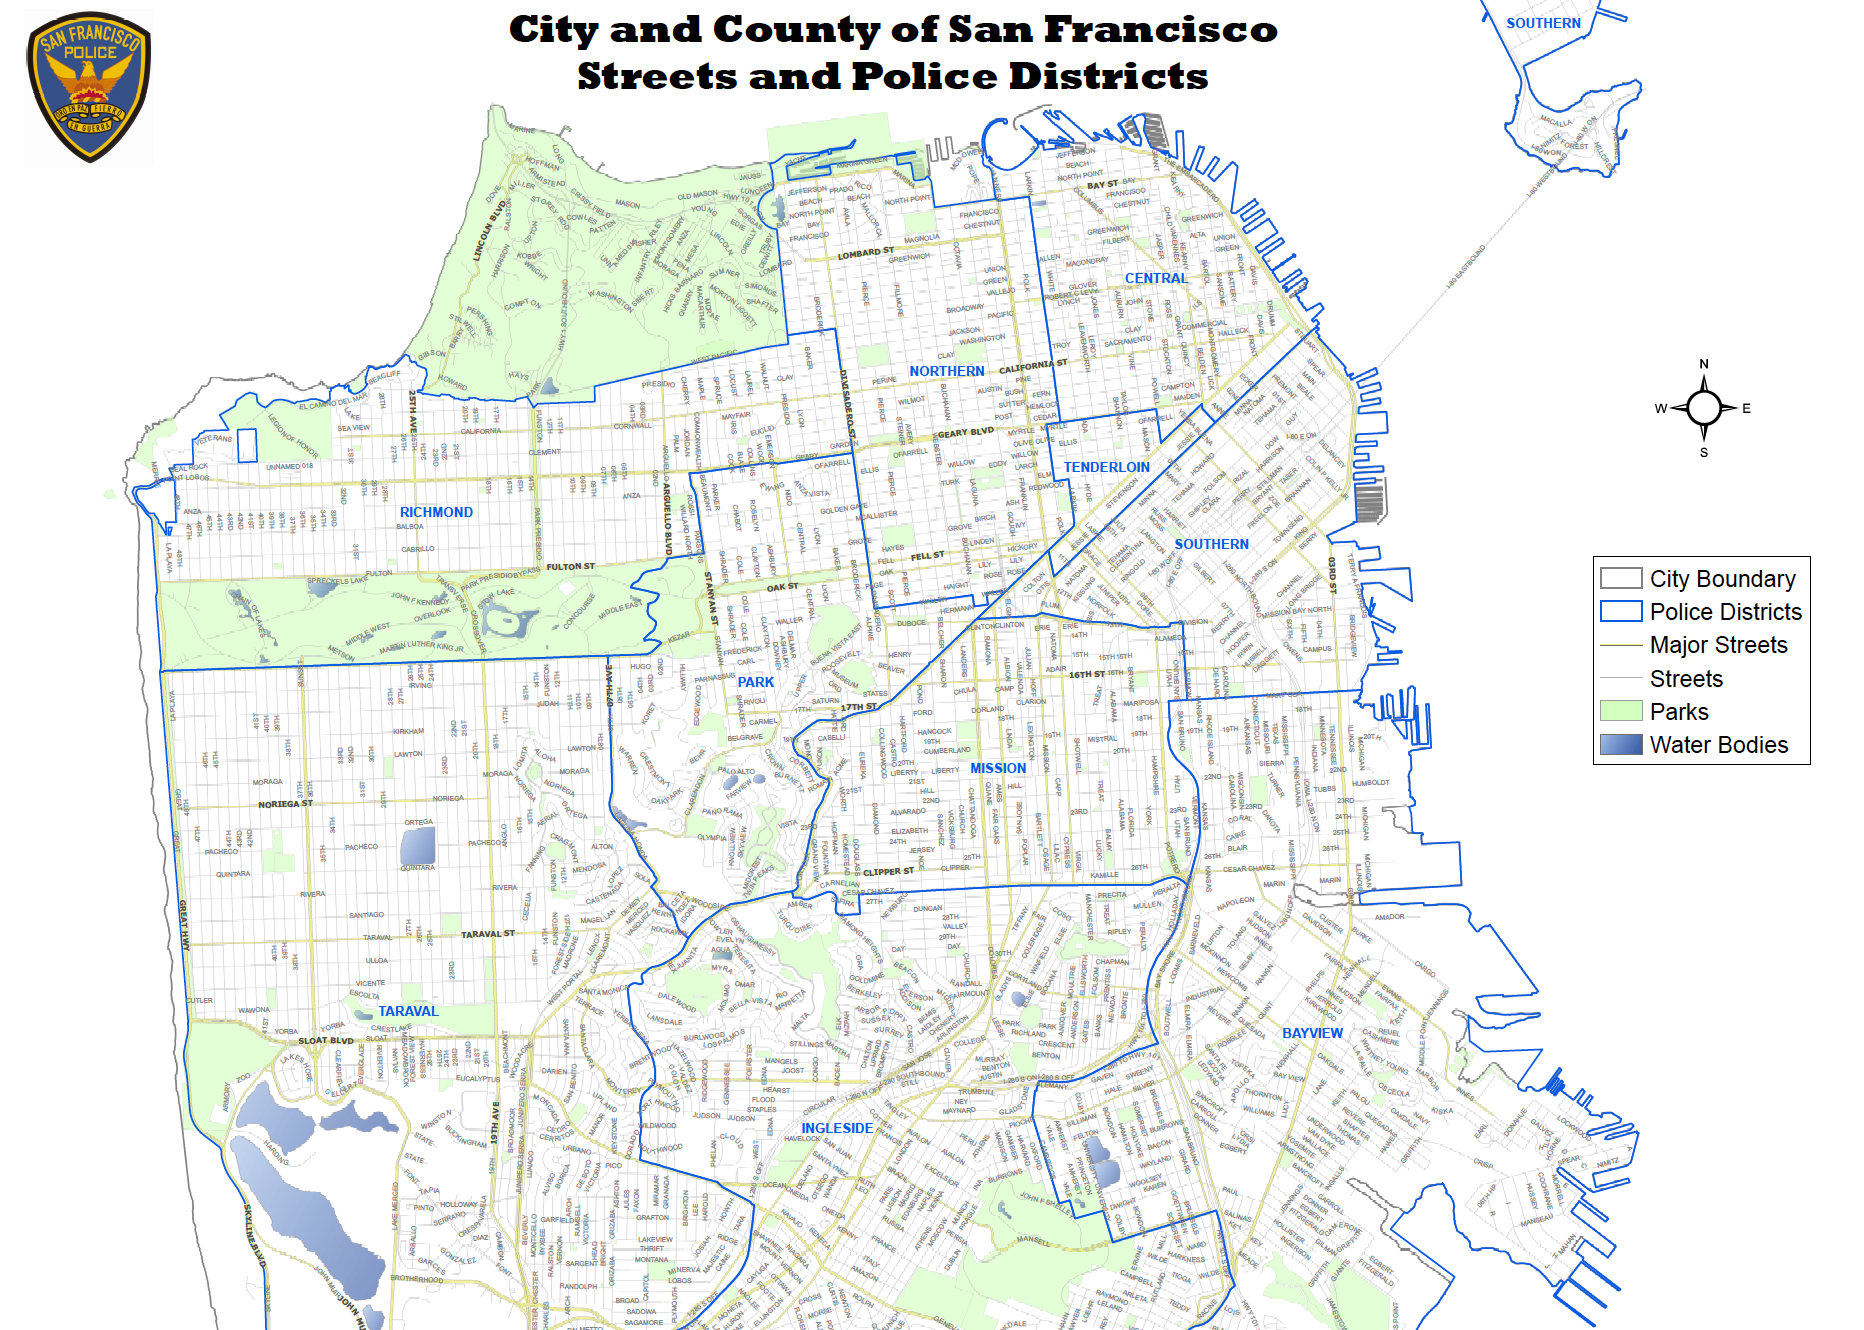

In [18]:
from IPython.display import Image
Image(filename='SF Police Districts PNG.png') 

### Number of Incidents by Date - Top 10, Bottom 10

In [19]:
df["Date"].value_counts().head(10)

12/15/16    82
12/29/16    80
10/28/16    79
10/14/16    75
12/20/16    73
12/30/16    73
5/27/16     70
11/12/16    69
11/25/16    69
11/15/16    68
Name: Date, dtype: int64

In [20]:
df["Date"].value_counts().tail(10)

8/22/16     30
1/12/16     29
5/8/16      29
1/4/16      28
8/25/16     27
5/18/16     26
8/28/16     25
4/10/16     25
12/25/16    25
3/13/16     21
Name: Date, dtype: int64

### Scatter Plot using coordinates

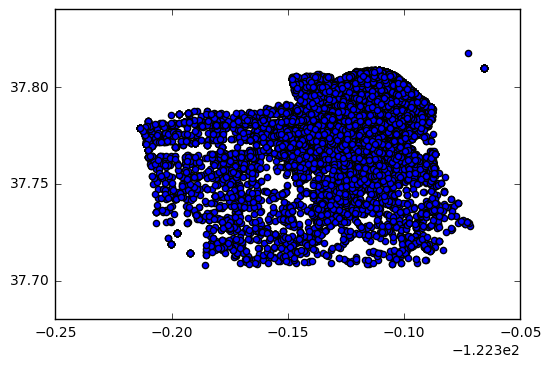

In [21]:

x = df.X
y = df.Y

plt.scatter(x, y)
plt.show()

### Heat Map

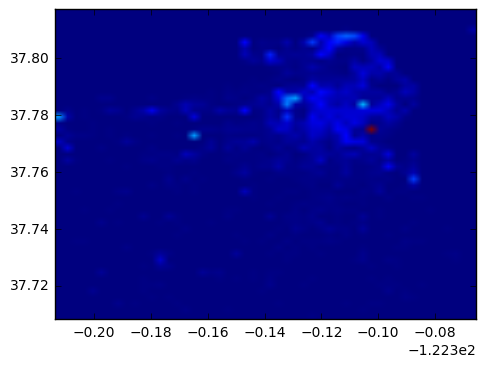

In [26]:

x = df.X
y = df.Y

heatmap, xedges, yedges = np.histogram2d(x, y, bins=50)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.clf()
plt.imshow(heatmap.T, extent=extent, origin='lower')
plt.show()